In [27]:
import os
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly

import nltk

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud

# Data Gathering

In [2]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/NLP'
!ls -la

/content/drive/My Drive/NLP
total 4
drwx------ 2 root root 4096 Feb 12 11:42 data


In [4]:
def fnc(path_headlines, path_bodies):

    map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}

    with open(path_bodies, encoding='utf_8') as fb:  # Body ID,articleBody
        body_dict = {}
        lines_b = csv.reader(fb)
        for i, line in enumerate(tqdm(list(lines_b), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[0].strip())
                body_dict[body_id] = line[1]

    with open(path_headlines, encoding='utf_8') as fh: # Headline,Body ID,Stance
        lines_h = csv.reader(fh)
        h = []
        b = []
        l = []
        for i, line in enumerate(tqdm(list(lines_h), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[1].strip())
                label = line[2].strip()
                if label in map and body_id in body_dict:
                    h.append(line[0])
                    l.append(map[line[2]])
                    b.append(body_dict[body_id])
    return h, b, l

data_dir = './data'
headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'combined_stances_train.csv'),
    os.path.join(data_dir, 'combined_bodies_train.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'label'])
train_df, val_df = train_test_split(df)
labels_val = pd.Series(val_df['label']).to_numpy()

headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'combined_stances_test.csv'),
    os.path.join(data_dir, 'combined_bodies_test.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
test_df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'label'])
labels_test = pd.Series(test_df['label']).to_numpy()

# Data Exploratory Analysis (Visualisation) 📊

In [5]:
train_df

,text_a,text_b,label
24965,Not coming to a store near you: The pumpkin sp...,Tiger Woods divorced Swedish model Elin Nordeg...,3
49131,US officials: Video shows American's execution,With Christian Bale already secured to play th...,3
10018,The Guy Who Said a Spider Burrowed Under His S...,"Boston - So lately, tongues have been wagging ...",3
13373,"James Wright Foley, Kidnapped Journalist, Appa...",Apple would never lower itself to rubbing elbo...,3
44160,Seven girls fall pregnant after five day schoo...,A Twitter user by the name of Cassy delivered ...,3
...,...,...,...
34903,Watch moment TV weatherman is caught urinating...,"Media outlets have identified ""Jihadi John"" - ...",3
45853,"Soldier, Gunman Killed In Shooting Incident Ne...",Knightscope co-founder Stacy Stephens said rum...,3
36853,US Marine survives headshot from Taliban (video),A hoax story about street artist Banksy being ...,3
22322,ISIS Beheads Kidnapped Photojournalist James W...,"KANSAS CITY, Mo. - Kansas City health official...",3


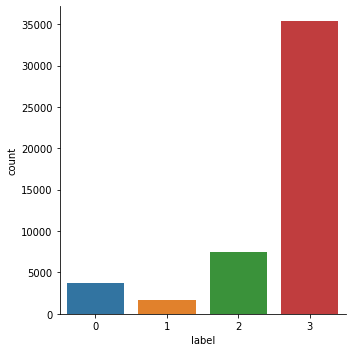

In [9]:
sns.catplot('label', data=train_df, kind='count')

In [12]:
labels = ['0',' 1','2','3']
values = [
      len(train_df[(train_df["label"] == 0)]), 
      len(train_df[(train_df["label"] == 1)]), 
      len(train_df[(train_df["label"] == 2)]), 
      len(train_df[(train_df["label"] == 3)]), 
]
colors = ['#FEBFBB', '#E13966']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))

plotly.offline.iplot([trace], filename='styled_pie_chart')

(-0.5, 399.5, 199.5, -0.5)

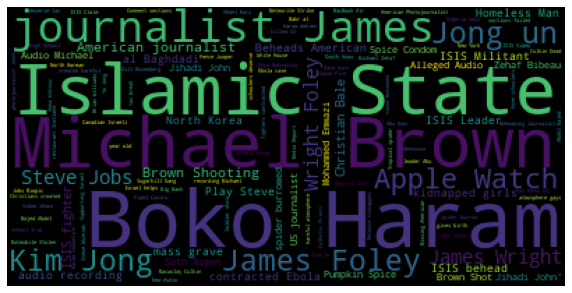

In [7]:
cloud = train_df.text_a.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.title("Words frequented in text_a", fontsize=15)
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

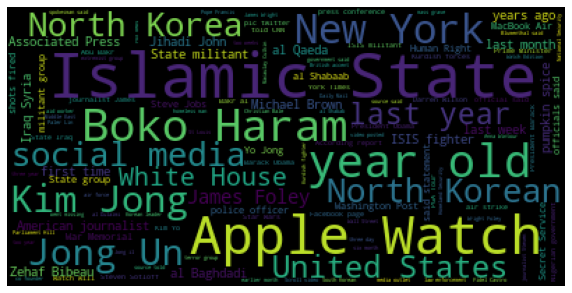

In [ ]:
cloud = train_df.text_b.tolist()
cloud_st = " ".join(cloud)
plt.title("Words frequented in text_b", fontsize=15)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

# Data Prepossessing

In [14]:
train_df.isnull().sum()

text_a    0
text_b    0
label     0
dtype: int64

In [16]:
# merging the author name and news title
train_df['content'] = train_df['text_a']+' '+train_df['text_b']

Split the label we want to predict

In [20]:
X= train_df.drop(columns='label', axis=1)
Y = train_df['label']
X.shape

(48153, 3)

### STEMMING:

A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
In simple words, Stemming is the process of reducing a word to its Root word.

In [28]:
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
def stemming(content):
    rev = re.sub('[^a-zA-Z]',' ',content)
    rev = rev.lower()
    rev = rev.split()
    rev = [ps.stem(word) for word in rev if not word in stopwords.words('english')]
    rev = ' '.join(rev)
    return rev

In [31]:
train_df['content'] = train_df['content'].apply(stemming)
train_df

separating the data and label

In [ ]:
X = train_df['content'].values
Y = train_df['label'].values

### TF-IDF
TF-IDF stands for “Term Frequency – Inverse Document Frequency ”

In [ ]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
X

# ML models

In [ ]:
## code here